Loading data from datasets

In [258]:
import pandas as pd

data_train = pd.read_csv("sample_data/train.tsv", sep="\t", header=None)
data_valid = pd.read_csv("sample_data/valid.tsv", sep="\t", header=None)
data_test = pd.read_csv("sample_data/test.tsv", sep="\t", header=None)

In [259]:
data_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


In [260]:
data_train.shape

(10240, 14)

In [261]:
filtered_data1 = data_train[data_train.iloc[:, 1] ==  'false']
filtered_data2 = data_train[data_train.iloc[:, 1]  == "pants-fire"]
filtered_data3 = data_train[data_train.iloc[:, 1]  == "true"]
filtered_data4 = data_train[data_train.iloc[:, 1]  == "mostly-true"]
filtered_data5 = data_train[data_train.iloc[:, 1]  == "half-true"]
filtered_data6 = data_train[data_train.iloc[:, 1]  == "barely-true"]

print(f"The number of rows with label false is: {filtered_data1.shape[0]}")
print(f"The number of rows with label pants-fire is: {filtered_data2.shape[0]}")
print(f"The number of rows with label true is: {filtered_data3.shape[0]}")
print(f"The number of rows with label mostly-true is: {filtered_data4.shape[0]}")
print(f"The number of rows with label half-true is: {filtered_data5.shape[0]}")
print(f"The number of rows with label barely-true is: {filtered_data6.shape[0]}")

The number of rows with label false is: 1995
The number of rows with label pants-fire is: 839
The number of rows with label true is: 1676
The number of rows with label mostly-true is: 1962
The number of rows with label half-true is: 2114
The number of rows with label barely-true is: 1654


convert 6 classes to 2 classes

In [262]:
def combine_classes(dataset):
    dataset['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in dataset[1]]
    
    #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context
    meta = []
    for i in range(len(dataset)):
      subject = dataset[3][i]
      if subject == 0:
          subject = 'None'

      speaker =  dataset[4][i]
      if speaker == 0:
          speaker = 'None'

      job =  dataset[5][i]
      if job == 0:
          job = 'None'

      state =  dataset[6][i]
      if state == 0:
          state = 'None'

      affiliation =  dataset[7][i]
      if affiliation == 0:
          affiliation = 'None'

      context =  dataset[13][i]
      if context == 0 :
          context = 'None'

      meta.append(str(subject) + ' ' + str(speaker) + ' ' + str(job) + ' ' + str(state) + ' ' + str(affiliation) + ' ' + str(context)) #combining all the meta data columns into a single column
  
    #Adding cleaned and combined metadata column to the dataset
    dataset[14] = meta
    dataset["sentence"] = dataset[14].astype('str')+" "+dataset[2]
    
    #Dropping unwanted columns
    dataset = dataset.drop(labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14] ,axis=1)
    dataset.dropna()
    return dataset

In [263]:
#Applying reduce_classes to the raw data - train, valid and test sets
data_train = combine_classes(data_train)
data_valid = combine_classes(data_valid)
data_test = combine_classes(data_test)
data_train.head(3)


,label,sentence
0,0,abortion dwayne-bohac State representative Tex...
1,0,"energy,history,job-accomplishments scott-surov..."
2,1,foreign-policy barack-obama President Illinois...


In [264]:
data_train['label'].value_counts(normalize='true')

0    0.644727
1    0.355273
Name: label, dtype: float64

In [265]:
data_tokenized_for_plot_train = data_train
data_tokenized_for_plot_train = data_train

Preproccesing

In [266]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def data_preprocessing(dataset):
    preprocessed_texts = []
    for text in dataset:
        # convert to lowercase
        text = text.lower()    
        # tokenize text
        tokens = word_tokenize(text)
        # remove punctuation and irrelevant characters
        filtered_tokens = [token for token in tokens if token.isalnum()]
        # remove stop words
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [token for token in filtered_tokens if not token in stop_words]
        # lemmatize tokens
        lemmatizer = WordNetLemmatizer()
        filtered_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        # stem tokens
        stemmer = PorterStemmer()
        filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]
        # join tokens back into string
        preprocessed_text = ' '.join(filtered_tokens)
        preprocessed_texts.append(preprocessed_text)
    return preprocessed_texts

In [267]:
data_train['sentence'] = data_preprocessing(data_train['sentence'])
data_valid['sentence'] = data_preprocessing(data_valid['sentence'])
data_test['sentence'] = data_preprocessing(data_test['sentence'])

data_train.head(5)

,label,sentence
0,0,abort state repres texa republican mailer say ...
1,0,energi histori state deleg virginia democrat f...
2,1,presid illinoi democrat denver hillari clinton...
3,0,nan nan none news releas health care reform le...
4,0,economi job nan florida democrat interview cnn...


Some little plays with datas

In [268]:
import pandas as pd

data = pd.concat([data_train, data_valid], ignore_index=True)
data = pd.concat([data, data_test], ignore_index=True)

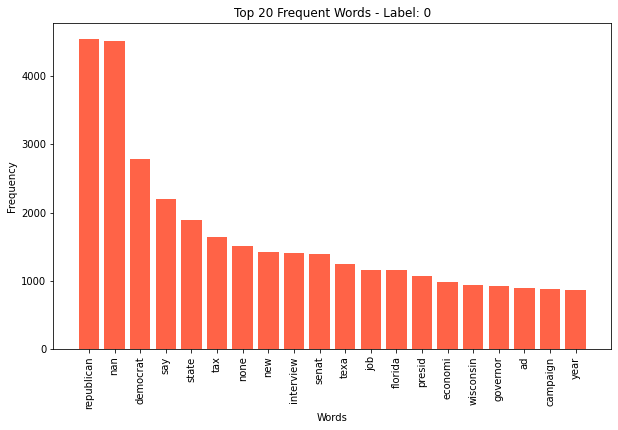

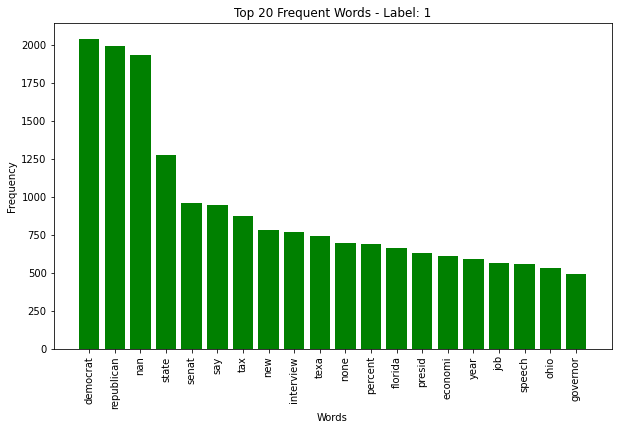

In [270]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

count_vectorizer = CountVectorizer()
grouped_data = data.groupby('label')
colors = ['tomato', 'green']
i=0
for label, group in grouped_data:
    # Extract the sentences for the current label
    sentences = group['sentence']

    # Fit the vectorizer on the sentences and transform the text into a matrix of token counts
    X = count_vectorizer.fit_transform(sentences)

    # Compute the sums of the counts for each word across all documents
    word_counts = X.sum(axis=0)

    # Get the frequency counts and corresponding words
    word_freq = [(word, word_counts[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]

    # Sort the word frequency list in descending order
    word_freq.sort(key=lambda x: x[1], reverse=True)

    # Extract the top 20 frequent words
    top_20_words = word_freq[:20]

    # Create lists of words and their corresponding frequencies
    words = [word for word, _ in top_20_words]
    frequencies = [freq for _, freq in top_20_words]

    # Plot the top 20 frequent words using a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies, color=colors[i])
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 20 Frequent Words - Label: {label}')
    plt.xticks(rotation=90)
    plt.show()
    i = i+1

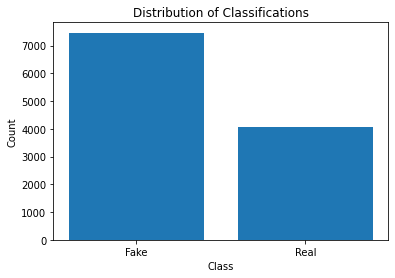

In [387]:
#Visualize distribution of datas 

import numpy as np

y=data_train_valid['label']
class_counts = np.bincount(y)
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']
plt.xticks(range(len(class_counts)), class_labels)
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Feature engineering

In [307]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def feature_engineering(X_train, X_test):
    vectorizer = TfidfVectorizer()
    X_train_valid_vectorized = vectorizer.fit_transform(X_train_valid)
    X_test_vectorized = vectorizer.transform(X_test)
    
    vocab_size = len(vectorizer.vocabulary_) + 1  # Vocabulary size for word embedding
    
    # Prepare the input sequences for the LSTM model
#     X_train_valid_sequences = pad_sequences(vectorizer.transform(X_train_valid).toarray(),
#                                             maxlen=100)
    
#     X_test_sequences = pad_sequences(vectorizer.transform(X_test).toarray(),
#                                      maxlen=100)

    X_train_valid_sequences = pad_sequences(vectorizer.transform(X_train_valid).toarray(),
                                            maxlen=150, truncating='post', padding='post')
    X_test_sequences = pad_sequences(vectorizer.transform(X_test).toarray(),
                                            maxlen=150, truncating='post', padding='post')
    return X_train_valid_vectorized, X_test_vectorized, vocab_size, X_train_valid_sequences, X_test_sequences


In [308]:
# Combine the training and validation datasets for training
data_train_valid = pd.concat([data_train, data_valid])
X_train_valid = data_train_valid['sentence']
y_train_valid = data_train_valid['label']
X_test = data_test['sentence']
y_test = data_test['label']

X_train_valid_vectorized, X_test_vectorized,vocab_size, X_train_valid_sequences, X_test_sequences =feature_engineering(X_train_valid, X_test)

SMOT

In [309]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = X_train_valid_vectorized
y = y_train_valid
smote = SMOTE()
X_train_valid_resampled, y_train_valid_resampled = smote.fit_resample(X, y)

#Convert resampled data to sequence
# X_train_valid_resampled_sequences = pad_sequences(X_train_valid_resampled.toarray(),
#                                                   maxlen=100)
X_train_valid_resampled_sequences = pad_sequences(X_train_valid_resampled.toarray(),
                                                  maxlen=150, truncating='post', padding='post')

print("Before SMOTE:", Counter(y))
print("After SMOTE:", Counter(y_train_valid_resampled))

Before SMOTE: Counter({0: 7466, 1: 4058})
After SMOTE: Counter({0: 7466, 1: 7466})


In [386]:
print(len([element for row in X_train_valid_resampled for element in row]))

14932


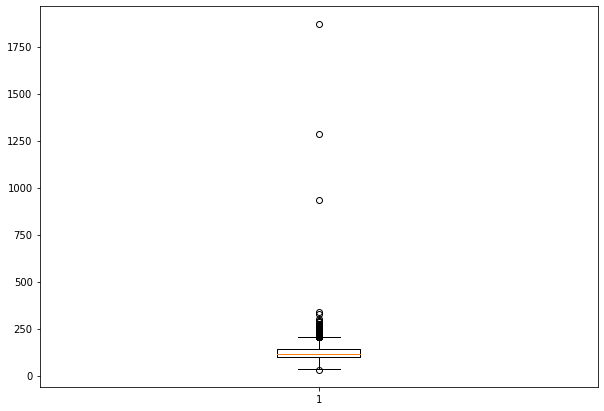

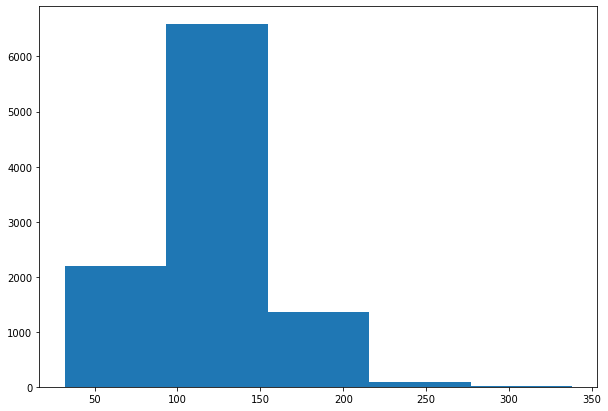

In [388]:
#Analyzing length of sentences in training data to decide on MAX_LENGTH variable, which is required for mlp and deep_leaner

sent_len = []
for sent in data_train['sentence']:
  sent_len.append(len(sent))

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
plt.boxplot(sent_len)
plt.show()

sent_len = [i for i in sent_len if i<=500] #Excluding the outliers
fig2 = plt.figure(figsize =(10, 7))
plt.hist(sent_len, 5)
plt.show()

First plot:The x-axis represents the sentence length, while the y-axis represents the distribution of lengths.

Second Histogram: It shows a histogram of the sentence lengths after excluding any outliers greater than 500 characters From the above histogram. The x-axis represents the range of sentence lengths, divided into bins (in this case, 5 bins), and the y-axis represents the frequency or count of sentences falling within each bin.The histogram provides insight into the distribution of sentence lengths and highlights any patterns or concentration of lengths within the dataset.

we can see that, majority of the sentences are in the range of 100-150 and the maximum is near 300.

Ensemble Model

1- SVM

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time

def train_svm_gridseach(X_train_valid_vectorized, y_train_valid, X_test_vectorized):
    start_time = time.time()

    param_grid = {
        'C': [1.0, 10.0],  # Regularization parameter
        'kernel': ['poly', 'rbf'],  # Kernel type
        'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf'
    }

    svm_model = SVC()

    # Define the Grid Search with cross-validation
    grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1_micro')
    grid_search.fit(X_train_valid_vectorized, y_train_valid)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print("Best parameters of SVM:", best_params)
    
    svm_train_valid_predictions = grid_search.predict(X_train_valid_vectorized)
    svm_predictions = grid_search.predict(X_test_vectorized)

    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time of SVM: {:.2f} seconds".format(execution_time))
    return svm_predictions,svm_train_valid_predictions

In [22]:
svm_predictions, svm_train_valid_predictions =train_svm_gridseach(X_train_valid_resampled,
                                                                  y_train_valid_resampled, X_test_resampled)

Best parameters of SVM: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Execution time of SVM: 3596.25 seconds


In [300]:
from sklearn.svm import SVC
import time

def train_svm():
    start_time = time.time()

    svm_model = SVC(C=10, gamma='scale', kernel='poly')
    svm_model.fit(X_train_valid_resampled, y_train_valid_resampled)
    svm_train_valid_predictions = svm_model.predict(X_train_valid_resampled)
    svm_predictions = svm_model.predict(X_test_vectorized)
    
    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time of SVM: {:.2f} seconds".format(execution_time))
    return svm_predictions, svm_train_valid_predictions


In [301]:
svm_predictions, svm_train_valid_predictions =train_svm()


Execution time of SVM: 163.57 seconds


In [302]:
from sklearn.metrics import precision_recall_fscore_support
accuracy = sum(svm_predictions == y_test) / len(y_test_resampled)

precision, recall, fscore, support = precision_recall_fscore_support(y_test,
                                                                     svm_predictions, average='binary')

print("Model4 - SVM - accuracy:", accuracy)
print("Model4 - SVM - Precision:", precision)
print("Model4 - SVM - Recall:", recall)
print("Model4 - SVM - F-score:", fscore)

Model4 - SVM - accuracy: 0.4889975550122249
Model4 - SVM - Precision: 0.4811715481171548
Model4 - SVM - Recall: 0.512249443207127
Model4 - SVM - F-score: 0.4962243797195253


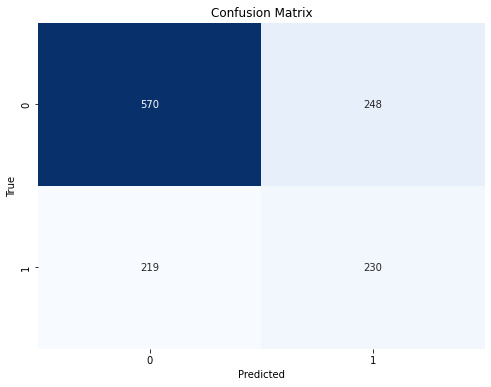

In [303]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, svm_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

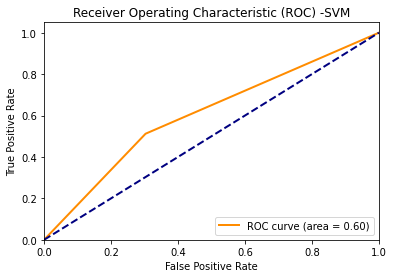

In [370]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute the true positive rate (tpr) and false positive rate (fpr) using roc_curve
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm_predictions)
svm_roc_auc = auc(svm_fpr, svm_tpr)

plt.figure()
plt.plot(svm_fpr, svm_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) -SVM')
plt.legend(loc="lower right")
plt.show()

2-LSTM

In [62]:
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time

def train_lstm_gridsearch():
    start_time = time.time()

    param_grid = {
        'embedding_dim': [100, 150, 200],
        'lstm_units': [32, 64, 128],
        'batch_size': [16, 32, 64]
    }
    
    lstm_model = Sequential()    
    lstm_model.add(Embedding(vocab_size, 150, input_length=100))
    lstm_model.add(LSTM(64))
    lstm_model.add(Dense(1, activation='relu'))
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    lstm_model.fit(X_train_valid_resampled_sequences, y_train_valid_resampled, epochs=10, batch_size=32)
    lstm_predictions = (lstm_model.predict(X_test_sequences) > 0.25).astype(int).flatten()

    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time of LSTM: {:.2f} seconds".format(execution_time))

    return lstm_predictions, lstm_train_valid_predictions, 

In [67]:
lstm_predictions_search, lstm_train_valid_predictions = train_lstm_gridsearch()

In [392]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time
import keras
from tensorflow.keras.optimizers import Adam

def train_lstm():
    start_time = time.time()
    loss_values=[]
  
    lstm_model = Sequential()
    lstm_model.add(Embedding(vocab_size, 150, input_length=150))
    lstm_model.add(LSTM(128,activation='elu',return_sequences=True))
    #lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(128,activation='elu'))
    #lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1, activation='sigmoid'))
    lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001),
                       metrics=['accuracy','Precision','Recall'])

    model_pred = lstm_model.predict(X_test_sequences)
    print(model_pred[:100])
    
    history = lstm_model.fit(X_train_valid_resampled_sequences, y_train_valid_resampled, batch_size=200,
                             epochs=50, validation_data=(X_test_sequences, y_test))
        
    lstm_train_valid_predictions = (lstm_model.predict(X_train_valid_resampled_sequences) > 0.3).astype(int).flatten()
    lstm_predictions = (model_pred > 0.3).astype(int).flatten()
    
    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time of LSTM: {:.2f} seconds".format(execution_time))
    return lstm_predictions,lstm_train_valid_predictions, history

# class LossHistory(keras.callbacks.Callback):
#     def __init__(self, loss_values):
#         self.loss_values = loss_values

#     def on_epoch_end(self, epoch, logs=None):
#         self.loss_values.append(logs['loss'])

In [393]:
lstm_predictions, lstm_train_valid_predictions, history = train_lstm()
print(lstm_predictions)

Epoch 1/50
75/75 [==============================] - 117s 2s/step - loss: 0.6934 - accuracy: 0.4912 - precision: 0.4917 - recall: 0.5224 - val_loss: 0.6943 - val_accuracy: 0.3544 - val_precision: 0.3544 - val_recall: 1.0000
Epoch 2/50
75/75 [==============================] - 133s 2s/step - loss: 0.6934 - accuracy: 0.4977 - precision: 0.4982 - recall: 0.6272 - val_loss: 0.6909 - val_accuracy: 0.6456 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 141s 2s/step - loss: 0.6933 - accuracy: 0.4953 - precision: 0.4946 - recall: 0.4328 - val_loss: 0.6943 - val_accuracy: 0.3544 - val_precision: 0.3544 - val_recall: 1.0000
Epoch 4/50
75/75 [==============================] - 144s 2s/step - loss: 0.6932 - accuracy: 0.4892 - precision: 0.4903 - recall: 0.5471 - val_loss: 0.6942 - val_accuracy: 0.3544 - val_precision: 0.3544 - val_recall: 1.0000
Epoch 5/50
75/75 [==============================] - 133s 2s/step - loss: 0.6932 - accuracy: 0.4958 -

Epoch 37/50
75/75 [==============================] - 187s 2s/step - loss: 0.6932 - accuracy: 0.4997 - precision: 0.4990 - recall: 0.1291 - val_loss: 0.6936 - val_accuracy: 0.3544 - val_precision: 0.3544 - val_recall: 1.0000
Epoch 38/50
75/75 [==============================] - 191s 3s/step - loss: 0.6932 - accuracy: 0.4972 - precision: 0.4972 - recall: 0.5016 - val_loss: 0.6939 - val_accuracy: 0.3544 - val_precision: 0.3544 - val_recall: 1.0000
Epoch 39/50
75/75 [==============================] - 190s 3s/step - loss: 0.6932 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000 - val_loss: 0.6933 - val_accuracy: 0.3544 - val_precision: 0.3544 - val_recall: 1.0000
Epoch 40/50
75/75 [==============================] - 193s 3s/step - loss: 0.6932 - accuracy: 0.4914 - precision: 0.4881 - recall: 0.3531 - val_loss: 0.6929 - val_accuracy: 0.6456 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 41/50
75/75 [==============================] - 185s 2s/step - loss: 0.6932 - accuracy: 0.5

In [322]:
print(y_test[:100])

0     1
1     0
2     0
3     0
4     0
     ..
95    0
96    1
97    0
98    0
99    0
Name: label, Length: 100, dtype: int64


In [ ]:
print(lstm-predi)

In [395]:
from sklearn.metrics import precision_recall_fscore_support
accuracy = sum(lstm_predictions == y_test) / len(y_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, lstm_predictions, average='binary')

print("Model4 - LSTM - accuracy:", accuracy)
print("Model4 - LSTM - Precision:", precision)
print("Model4 - LSTM - Recall:", recall)
print("Model4 - LSTM - F-score:", fscore)

Model4 - LSTM - accuracy: 0.35438042620363064
Model4 - LSTM - Precision: 0.35438042620363064
Model4 - LSTM - Recall: 1.0
Model4 - LSTM - F-score: 0.5233100233100234


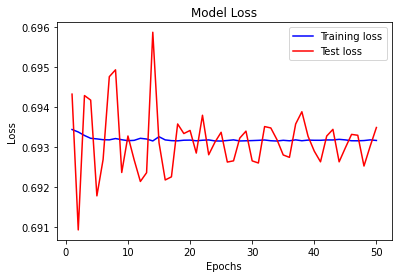

In [394]:
import numpy as np
import matplotlib.pyplot as plt

train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

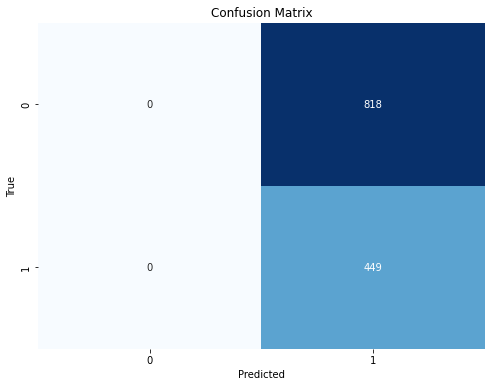

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, lstm_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

3- Passive Aggressive

In [126]:
from sklearn.linear_model import PassiveAggressiveClassifier
import time

def train_pa_gridshearch():
    start_time = time.time()
    param_grid = {
    'C': [0.1,0.5,],              # Regularization parameter
    'fit_intercept': [True, False],
    'max_iter': [500,1000],          # Maximum number of iterations
    'tol': [1e-6, 1e-7]              # Tolerance for stopping criterion
}
   # Create a PassiveAggressiveClassifier
    pa = PassiveAggressiveClassifier()

    grid_search = GridSearchCV(pa, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_valid_resampled, y_train_valid_resampled)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Score:", best_score)
    

In [127]:
train_pa_gridshearch()

Best Parameters: {'C': 0.1, 'fit_intercept': True, 'max_iter': 1000, 'tol': 1e-07}
Best Score: 0.7230178507401239


In [365]:
from sklearn.linear_model import PassiveAggressiveClassifier
import time

def train_pa():
    start_time = time.time()
    
    pa_model = PassiveAggressiveClassifier(C = 0.01, random_state = 42, max_iter=1000, early_stopping=True, tol=1e-9)
    pa_model.fit(X_train_valid_resampled, y_train_valid_resampled)
    pa_train_valid_predictions = pa_model.predict(X_train_valid_resampled)
    pa_predictions = pa_model.predict(X_test_vectorized)
    y_scores = pa_model.decision_function(X_test_vectorized)
    
    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time of PA: {:.2f} seconds".format(execution_time))
    return pa_predictions,pa_train_valid_predictions,y_scores

In [366]:
pa_predictions,pa_train_valid_predictions,pa_scores =train_pa()

Execution time of PA: 0.04 seconds


In [367]:
from sklearn.metrics import precision_recall_fscore_support
accuracy = sum(pa_predictions == y_test) / len(y_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, pa_predictions, average='binary')

print("Model4 - PA - accuracy:", accuracy)
print("Model4 - PA - Precision:", precision)
print("Model4 - PA - Recall:", recall)
print("Model4 - PA - F-score:", fscore)

Model4 - PA - accuracy: 0.6085240726124704
Model4 - PA - Precision: 0.4614121510673235
Model4 - PA - Recall: 0.6258351893095768
Model4 - PA - F-score: 0.5311909262759924


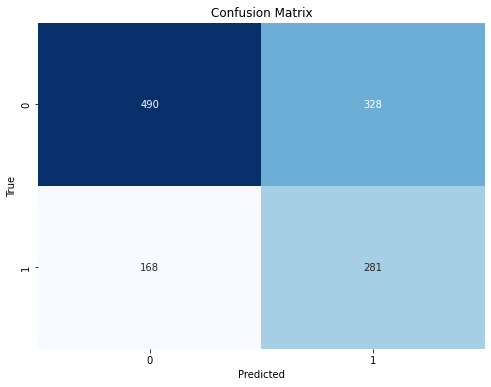

In [368]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pa_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

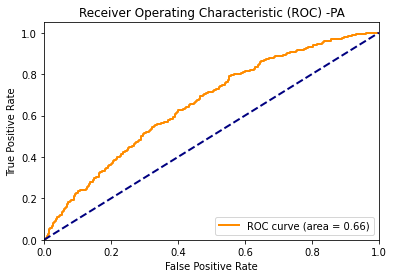

In [369]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

pa_fpr, pa_tpr, pa_thresholds = roc_curve(y_test, pa_scores)
pa_roc_auc = auc(pa_fpr, pa_tpr)

# Plot ROC curve
plt.figure()
plt.plot(pa_fpr, pa_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % pa_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) -PA')
plt.legend(loc="lower right")
plt.show()

XGBoost

In [440]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

def train_xgboost_search():
    dtrain = xgb.DMatrix(X_train_valid_resampled, label=y_train_valid_resampled)
    dtest = xgb.DMatrix(X_test_vectorized, label=y_test)
                        
    # Define the parameter grid to search over
    param_grid={
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss'],
    'eta': [0.01, 0.1],  # learning rate
    'max_depth': [15, 20, 25],  # maximum depth of a tree
    'subsample': [0.2, 0.5],  # subsample ratio of the training instances
    'colsample_bytree': [0.5, 0.8]  # subsample ratio of columns when constructing each tree
    }

    num_rounds = 300  # number of boosting rounds (iterations)

    xgb_model = xgb.XGBClassifier()

    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=10)
    grid_search.fit(X_train_valid_resampled, y_train_valid_resampled)

    best_params = grid_search.best_params_
    print("Best Parameters found by Grid Search:", best_params)

    model = xgb.train(best_params, dtrain, num_rounds)
    y_pred = model.predict(dtest)
    y_pred_binary = [1 if p >= 0.4 else 0 for p in y_pred]

    return y_pred_binary

In [441]:
out= train_xgboost_search()

Best Parameters found by Grid Search: {'colsample_bytree': 0.8, 'eta': 0.1, 'eval_metric': 'logloss', 'max_depth': 25, 'objective': 'binary:logistic', 'subsample': 0.5}


In [452]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc

def train_xgboost():
    start_time = time.time()
    
    dtrain = xgb.DMatrix(X_train_valid_resampled, label=y_train_valid_resampled)
    dtest = xgb.DMatrix(X_test_vectorized, label=y_test)
    
    params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.01,  # learning rate
    'max_depth': 20,  # maximum depth of a tree
    'subsample': 0.2,  # subsample ratio of the training instances
    'colsample_bytree': 0.8  # subsample ratio of columns when constructing each tree
    }
    
    num_rounds = 300  # number of boosting rounds (iterations)     
    model = xgb.train(params, dtrain, num_rounds)
    y_pred = model.predict(dtest)

    y_train_valid_predictions = model.predict(dtrain)
    y_pred_binary = [1 if p >= 0.4 else 0 for p in y_pred]
    xgb_train_valid_predictions = [1 if p >= 0.4 else 0 for p in y_train_valid_predictions]
    
    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time of PA: {:.2f} seconds".format(execution_time))
    
    return y_pred_binary, xgb_train_valid_predictions, y_pred

In [453]:
xgb_predictions, xgb_train_valid_predictions, xgb_pred = train_xgboost()

Execution time of PA: 89.81 seconds


In [454]:
from sklearn.metrics import precision_recall_fscore_support
accuracy = sum(xgb_predictions == y_test) / len(y_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, xgb_predictions, average='binary')

print("Model4 - XGBoost - accuracy:", accuracy)
print("Model4 - XGBoost - Precision:", precision)
print("Model4 - XGBoost - Recall:", recall)
print("Model4 - XGBoost - F-score:", fscore)

Model4 - XGBoost - accuracy: 0.6227308602999211
Model4 - XGBoost - Precision: 0.47387387387387386
Model4 - XGBoost - Recall: 0.5857461024498887
Model4 - XGBoost - F-score: 0.5239043824701195


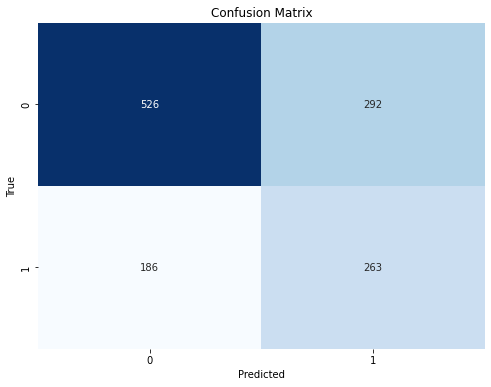

In [455]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, xgb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

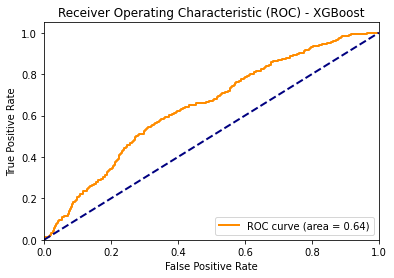

In [456]:
import matplotlib.pyplot as plt

xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_pred)
xgb_roc_auc = auc(xgb_fpr,xgb_tpr)

# Plot ROC curve
plt.figure()
plt.plot(xgb_fpr, xgb_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost')
plt.legend(loc="lower right")
plt.show()

Evaluate Ensemblely!

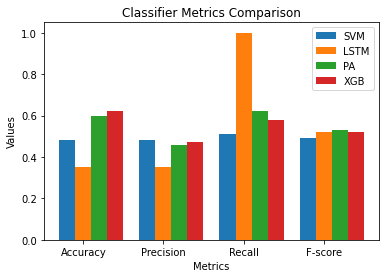

In [457]:
import numpy as np  
import matplotlib.pyplot as plt  
  
metrics = ['Accuracy','Precision','Recall','F-score'] 
svm = [0.48,0.48,0.51,0.49] 
lstm = [0.35,0.35,1.0,0.52] 
pa=[0.60,0.46,0.62,0.53]
xgb=[0.62,0.47,0.58,0.52]

bar_width = 0.2 
index = np.arange(len(metrics))
plt.bar(index, svm, bar_width, label='SVM')
plt.bar(index + bar_width, lstm, bar_width, label='LSTM')
plt.bar(index + 2*bar_width, pa, bar_width, label='PA')
plt.bar(index + 3*bar_width, xgb, bar_width, label='XGB')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Classifier Metrics Comparison')

plt.xticks(index + bar_width, metrics)
plt.legend()
plt.show()
        

In [459]:
import numpy as np
def ensemble_prediction():
    
    votes = np.array([list(row) for row in zip(svm_predictions, lstm_predictions ,xgb_predictions, pa_predictions)])
    column_sums = np.sum(votes, axis=1)
    averages_vote = []
    for column_sum in column_sums:
        average = column_sum / 4
        averages_vote.append(average.round())
    return averages_vote

In [460]:
from sklearn.metrics import precision_recall_fscore_support
# Ensemble predictions by majority voting
y_pred_ensemble = ensemble_prediction()

accuracy = sum(y_pred_ensemble == y_test) / len(y_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_ensemble, average='binary')
print("Model4 - accuracy:", accuracy)
print("Model4 - Precision:", precision)
print("Model4 - Recall:", recall)
print("Model4 - F-score:", fscore)

Model4 - accuracy: 0.6172059984214681
Model4 - Precision: 0.4673913043478261
Model4 - Recall: 0.5746102449888641
Model4 - F-score: 0.5154845154845155


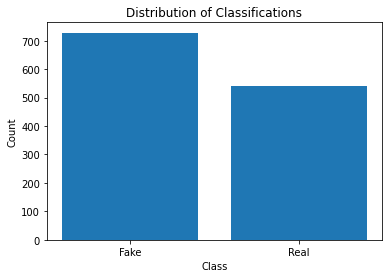

In [379]:
#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(y_pred_ensemble)
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']
plt.xticks(range(len(class_counts)), class_labels)
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

MLP Classifier 2

In [461]:
xgb_train_valid_predictions = np.array(xgb_train_valid_predictions)
xgb_predictions= np.array(xgb_predictions)

stacked_X_train = np.hstack((X_train_valid_resampled.toarray(), 
                             svm_train_valid_predictions.reshape((-1, 1)),
                             xgb_train_valid_predictions.reshape((-1, 1)),
                             lstm_train_valid_predictions.reshape((-1, 1)),
                             pa_train_valid_predictions.reshape((-1, 1))))
stacked_X_test = np.hstack((X_test_vectorized.toarray(), 
                            svm_predictions.reshape((-1, 1)),
                            xgb_predictions.reshape((-1, 1)),
                            lstm_predictions.reshape((-1, 1)),
                            pa_predictions.reshape((-1, 1))))


In [462]:
from sklearn.neural_network import MLPClassifier
import time

def build_mlp():
    start_time = time.time()
    
    mlp_classifier = MLPClassifier()
    mlp_classifier.fit(stacked_X_train, y_train_valid_resampled)

    mlp_predictions = mlp_classifier.predict(stacked_X_test)
    
    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time of MLP: {:.2f} seconds".format(execution_time))
    return mlp_predictions

In [463]:
mlp_predictions = build_mlp()

Execution time of MLP: 142.97 seconds


In [464]:
from sklearn.metrics import accuracy_score,f1_score, classification_report

f_score = f1_score(y_test, mlp_predictions, average='micro')
accuracy = accuracy_score(y_test, mlp_predictions)
print(classification_report(y_test, mlp_predictions))
print("Model4 - MLP F-score:", f_score)
print("Model4 - MLP Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       818
           1       0.48      0.51      0.50       449

    accuracy                           0.63      1267
   macro avg       0.60      0.60      0.60      1267
weighted avg       0.64      0.63      0.63      1267

Model4 - MLP F-score: 0.6314127861089187
Model4 - MLP Accuracy: 0.6314127861089187
